In [50]:
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import plotly.express as px

Installing graphviz:
```python
conda install graphviz
conda install python-graphviz
conda install pydot
```

In [2]:
from graphviz import Digraph

def draw_dag(edge_list: List[str], condition_on: List[str] = [], horizontal:bool = True) -> Digraph:
    """Create a DAG visualization.
    
    Args:
        edge_list (List[str]): A list of strings with 2 characters each.
            These characters will be treated as the start and end nodes of each directed edge.
        condition_on (List[str], optional): Nodes to condition on, will be rendered as a box.
    """
    nodes = set("".join(edge_list))
    assert set(condition_on).issubset(nodes), f"{set(condition_on)-nodes} not found in edge_list."
    kwargs = dict(graph_attr = dict(rankdir= "LR")) if horizontal else dict()
    dot = Digraph(**kwargs)
    for node in nodes:
        shape = "box" if node in condition_on else "ellipse"
        dot.node(node, node, shape=shape)
    dot.edges(edge_list)
#     dot.body.append("graph [splines=false];")
    return dot

In [3]:
def correlation_diags(X,Y):
    """Regress X on Y then display plot and pvalue."""
    plt.scatter(X,Y, alpha = 0.5)
    plt.show()
    r, pval = pearsonr(X,Y)
    print(f"Pearson's R = {r}")

# Overview

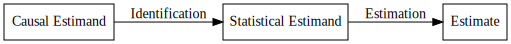

In [4]:
dot = Digraph(graph_attr = dict(rankdir= "LR"))
dot.node("A", "Causal Estimand", shape = 'box')
dot.node("B", "Statistical Estimand", shape = 'box')
dot.node("C", "Estimate", shape = 'box')
dot.edge("A","B", label = "Identification")
dot.edge("B","C", label = "Estimation")
dot

In this notebook, we'll be focusing on **Identification**.

# Bayesian Networks
1. Represented as a **Directed Acyclic Graph (DAG)**.
2. Graphical model that represent **conditional dependencies** between variables.
3. Represents the joint probability distribution as a **factor product**.

## 1. Directed Acyclic Graphs (DAGs)
Simply means that there are no cycles in the graph. i.e. following any path should not bring you back to where you started.

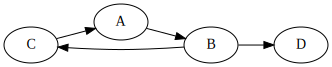

In [5]:
# cyclic
draw_dag(["AB", "BC", "CA", "BD"])

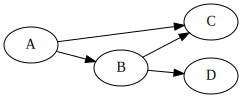

In [6]:
# acyclic
draw_dag(["AB", "AC", "BC","BD"])

## 2. Representing Conditional Dependencies
- The Bayesian Network DAG contains all the information needed for us to know all conditonal dependencies between any pair of variables. That is, which pairs are independent (or not).
 - Variables X and Y are conditionally independent on Z iff $P(X|C)P(Y|C) = P(X,Y|C)$. But X and Y are not necessarily independent.
- The rules that allow us to see dependencies in the DAG are known as **d-separation rules** which we'll get back to later.
- But here is a simple example where $A\perp \!\!\! \perp B$:

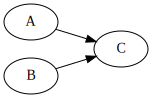

In [7]:
# A and B are independent. We'll get to see why they are independent later on...
draw_dag(["AC", "BC"])

## 3. Joint Distribution as a Factor Product
$$P(x_1, x_2, \dots, x_n) = \prod_i P(x_i|pa_i)$$
where $pa_i$ are the parent nodes of $x_i$. 

Condider this graph for example:

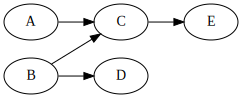

In [8]:
#sample graph
draw_dag(["AC","CE","BC","BD"])

the joint distribution of the graph can be expressed as
$$P(A,B,C,D,E) = P(A)P(B)P(C|A,B)P(D|B)P(E|C)$$

In practice, the probabilities are expressed and stored as probability tables. **Factor product** simply means that we are taking all possible combinations of the columns. For example,

In [9]:
# let P(A) and P(B) be represented as
print("P(A):")
display(pd.DataFrame({
    "a":[0,1],
    "P(A=a)":[0.6,0.4]
}))
print("------------")
print("P(B):")
display(pd.DataFrame({
    "b":[0,1,2],
    "P(B=b)":[0.2,0.5,0.3]
}))

P(A):


,a,P(A=a)
0,0,0.6
1,1,0.4


------------
P(B):


,b,P(B=b)
0,0,0.2
1,1,0.5
2,2,0.3


In [10]:
# they're factor product will then be
print("P(A) x P(B):")
display(pd.DataFrame({
    "a":[0,0,0,1,1,1],
    "b":[0,1,2,0,1,2],
    "P(A=a)P(B=b)":[0.1,0.3,0.2,0.15,0.05,0.2]
}))

P(A) x P(B):


,a,b,P(A=a)P(B=b)
0,0,0,0.10
1,0,1,0.30
2,0,2,0.20
3,1,0,0.15
4,1,1,0.05
5,1,2,0.20


The practical use of this is that it makes computing and storing large probability distributions more feasible. In the example above, notice that by storing P(A) and P(B) separately, we only need to store `2 + 3 = 5` rows instead of `2 * 3 = 6`.

## How do we know if our Bayesian Network is correct?

>“In so far as a scientific statement speaks about reality, it must be falsifiable: and in so far as it is not falsifiable, it does not speak about reality.” - *Karl Popper*

From a given network, we can tell all the conditional independence relationships between the variables. Thus, verifying the network is just a matter of testing if these independence relationships hold. If at least one of them fails, then the network is falsified.

## Warning! Bayesian Networks are not unique.
At times, we can have multiple networks that we fail to falsify. For example,

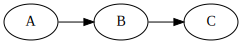

In [11]:
draw_dag(["AB", "BC"])

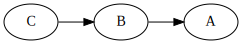

In [12]:
draw_dag(["CB", "BA"])

Both graphs above give the the same independence relationship: $A \perp \!\!\! \perp C|B$. So they are both valid. This brings us to the next point.

## Causal DAGs ≠ Bayesian Networks
- Although Causal DAGs are a kind Bayesian Networks, not all Bayesian Networks are Causal DAGs. 
- Causal DAGs have the extra requirement that **the arrows represent direct causal relationships**.
- Since Bayesian Networks are not unique (like the sample above), selecting the one with the correct causal relationships depends on **expert knowledge**.

### For example.
The first one makes sense while the second one doesn't. This determination depended on our knowledge of the world.

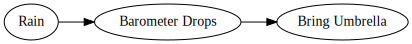

In [13]:
# example
dot = Digraph(graph_attr = dict(rankdir= "LR"))
dot.node("A", "Rain")
dot.node("B", "Barometer Drops")
dot.node("C", "Bring Umbrella")
dot.edges(["AB", "BC"])
dot

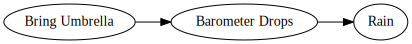

In [14]:
dot = Digraph(graph_attr = dict(rankdir= "LR"))
dot.node("A", "Rain")
dot.node("B", "Barometer Drops")
dot.node("C", "Bring Umbrella")
dot.edges(["CB", "BA"])
dot

## Heads up
- Causal DAGs only tell us if there are causal relationships between variables, not *how* they are related. 
- DAGs allow us to get simple measurements like **ATE** which can readily be observed from the data (with some adjustments).
- For modeling, i.e. estimating/predicting counterfactual information on an individual level, Causal DAGs can be extended to **Structual Causal Models (SCMs)**. But this will not be covered in this presentation.

# d-separation rules
- A set of rules that tell us if 2 variables in a network are d-separated.
- d-separated variables are **independent**
- If 2 variables are not d-separated, they are d-connected. d-connected variables are *likely* to be dependent, but is not guaranteed. You can have cases of d-connected variables that are independent (known as pathological cases).

## Rule 1. Conditional Independence in Chains.
> Two variables, X and Y, are conditionally independent given Z, if there is only one unidirectional path between X and Y and Z is any set of variables that intercepts that path. <br><div style="text-align:right"><i>-- "Causal Inference in Statistics" verbatim</i></div>

In other words, conditioning on a chain "blocks" the path. For example,

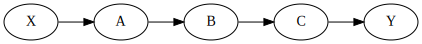

In [15]:
draw_dag(["XA","AB", "BC", "CY"])

Here, conditioning on at least one of A,B, or C will block the path from X to Y. That is $Z \subset \{A,B,C\} \implies X \perp \!\!\! \perp Y |Z$.

### Proof

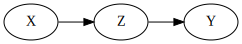

In [16]:
draw_dag(["XZ","ZY"])

The graph above will have the following factorization:
$$P(X,Y,Z) = P(X)P(Z|X)P(Y|Z)$$
By definition of conditional probabilities:
$$P(X,Y|Z) = \frac{P(X,Y,Z)}{P(Z)} = \frac{P(X)P(Z|X)P(Y|Z)}{P(Z)}$$
Using Bayes' Rule:
$$P(X,Y|Z) = \frac{P(X)(P(X|Z)P(Z)/P(X))P(Y|Z)}{P(Z)}$$
Therefore,
$$P(X,Y|Z) = P(X|Z)P(Y|Z) \implies X \perp \!\!\! \perp Y |Z$$

### Simulation

In [58]:
# X -> Z -> Y
X = np.random.normal(size = 10000)
Z = 200*X + 5 + np.random.normal(scale = 50, size = 10000)
Y = -40*Z + 10 + np.random.normal(size = 10000)
sim_df = pd.DataFrame(dict(X=X, Z=Z, Y=Y))

In [69]:
pd.cut(Z, 10)

[(-129.212, 21.986], (21.986, 173.184], (21.986, 173.184], (173.184, 324.382], (-280.409, -129.212], ..., (-129.212, 21.986], (324.382, 475.579], (173.184, 324.382], (21.986, 173.184], (-129.212, 21.986]]
Length: 10000
Categories (10, interval[float64]): [(-735.514, -582.805] < (-582.805, -431.607] < (-431.607, -280.409] < (-280.409, -129.212] ... (173.184, 324.382] < (324.382, 475.579] < (475.579, 626.777] < (626.777, 777.975]]

In [71]:
px.scatter(x=X, y=Y, color= pd.cut(Z,10), template="plotly_white")

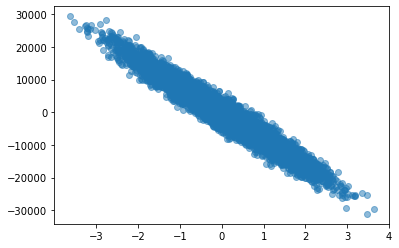

Pearson's R = -0.9702833461685809


In [60]:
# comparing X,Y unconditionally
correlation_diags(X,Y)

Notice that each color creates a horizontal cross section. This shows that X and Y are independent for each stratum of Z even if they have a correlation across all Z's.

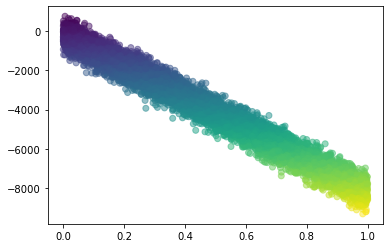

In [19]:
plt.scatter(X,Y, c=Z, alpha = 0.5)
plt.show()

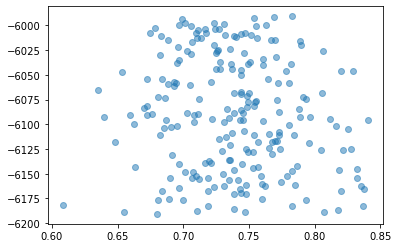

Pearson's R = -0.12075094090023493


In [20]:
# comparing X,Y | Z
cond_df = sim_df[(sim_df["Z"] > 150) & (sim_df["Z"] < 155)]
cond_X = cond_df["X"]
cond_Y = cond_df["Y"]
correlation_diags(cond_X, cond_Y)

## Rule 2. Conditional Independence in Forks
> If a variable X is a common cause of variables Y and Z, and there is only one path between Y and Z, then Y and Z are independent conditional on X. <br><div style="text-align:right"><i>-- "Causal Inference in Statistics" verbatim</i></div>

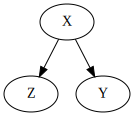

In [21]:
draw_dag(["XY", "XZ"], horizontal = False)

For this graph, $$Y \perp \!\!\!\perp Z|X$$

### Proof
The graph above has the following factorization:
$$P(X,Y,Z) = P(X)P(Y|X)P(Z|X)$$
It is easy to see that
$$P(Y,Z|X) = \frac{P(X,Y,Z)}{P(X)} = \frac{P(X)P(Y|X)P(Z|X)}{P(X)}$$
$$P(Y,Z|X) = P(Y|X)P(Z|X) \implies Y \perp \!\!\! \perp Z |X$$

### Simulation

In [83]:
# Z <- X -> Y
X = np.random.normal(size = 10000)
Z = 235*X + 5 + np.random.normal(scale = 100, size = 10000)
Y = -240*X + 10 + np.random.normal(size = 10000)
sim_df = pd.DataFrame(dict(X=X, Z=Z, Y=Y))

In [88]:
px.scatter(x=Z, y=Y, color= pd.cut(X,10), template="plotly_white",
          labels={"x":"z"})

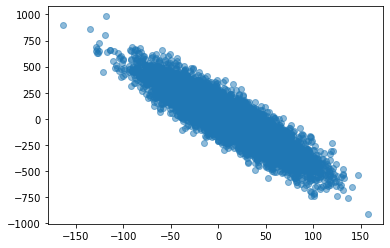

Pearson's R = -0.8951501413002585


In [49]:
# Y and Z, unconditional
correlation_diags(Y,Z)

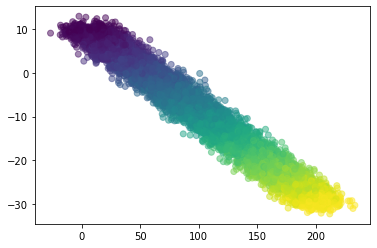

In [24]:
plt.scatter(Z,Y, c=X, alpha = 0.5)
plt.show()

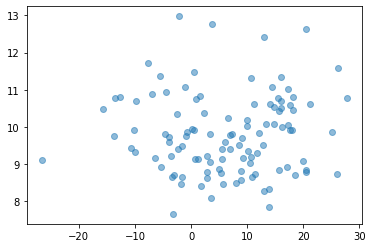

Pearson's R = 0.045260153116843824


In [25]:
# comparing Y,Z | X
cond_df = sim_df[(sim_df["X"] > 0) & (sim_df["X"] < 0.01)]
cond_Z = cond_df["Z"]
cond_Y = cond_df["Y"]
correlation_diags(cond_Z, cond_Y)

## Rule 3. Conditional Independence in Colliders
> If a variable Z is the collision node between X and Y, and there is only one path between X and Y, then X and Y and unconditionally independent but are dependent conditional on Z and any descendants of Z.<br><div style="text-align:right"><i>-- "Causal Inference in Statistics" verbatim</i></div>

Let's explore this without the descendants first.

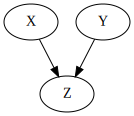

In [26]:
draw_dag(["XZ", "YZ"], horizontal = False)

Colliders are interesting because conditioning on them produces the opposite effect compared to chains and forks. In this case,
$$ X \perp \!\!\! \perp Y$$
but
$$ X \not \perp \!\!\! \perp Y |Z$$
Conditioning on Z actually opens the path! This structure is central in the concept of **M-bias** which we'll cover later. M-bias refers to the introduction of dependence (selection bias) when we unintentionally control for a collider. This means that controlling for all covariates is not always a good idea.

### Proof
This is also very straightforward. As usual, we start with the factor product:
$$P(X,Y,Z) = P(X)P(Y)P(Z|X,Y)$$
then we marginalize Z
$$\sum_{z\in Z}P(X,Y,Z) = P(X)P(Y)\sum_{z\in Z}P(Z|X,Y)$$
$$P(X,Y) = P(X)P(Y) \implies X \perp \!\!\! \perp Y$$

### Simulation

In [94]:
# X -> Z <- Y
X = np.random.normal(size = 10000)
Y = np.random.normal(size = 10000)
Z = 3*X + 5*Y + np.random.normal()
sim_df = pd.DataFrame(dict(X=X, Z=Z, Y=Y))

In [97]:
px.scatter(x=X, y=Y, color= pd.cut(Z,10), template="plotly_white")

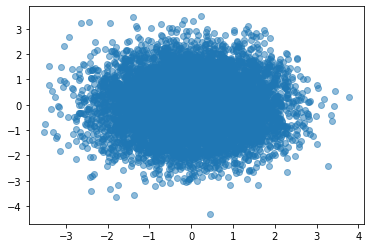

Pearson's R = 0.012152501162354508


In [90]:
correlation_diags(X,Y)

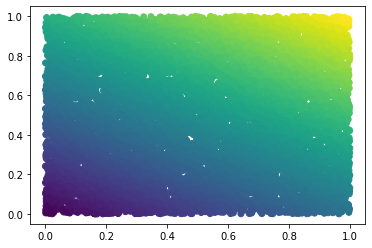

In [29]:
plt.scatter(X,Y, c=Z)
plt.show()

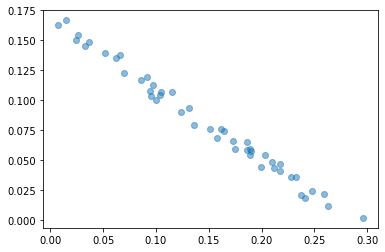

Pearson's R = -0.9939092961559081


In [30]:
# comparing X,Y | Z
cond_df = sim_df[(sim_df["Z"] > 1) & (sim_df["Z"] < 1.1)]
cond_X = cond_df["X"]
cond_Y = cond_df["Y"]
correlation_diags(cond_X, cond_Y)

Conditioning on the descendants of a collider can also create dependence:

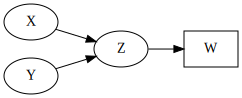

In [31]:
draw_dag(["XZ", "YZ", "ZW"], condition_on="W")

In [32]:
X = np.random.uniform(size = 10000)
Y = np.random.uniform(size = 10000)
Z = 3*X + 5*Y + np.random.normal()
W = 6*Z + np.random.normal()
sim_df = pd.DataFrame(dict(X=X, Z=Z, Y=Y, W=W))

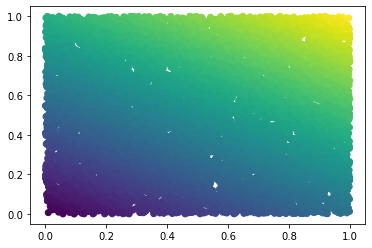

In [33]:
plt.scatter(X,Y, c=W)
plt.show()

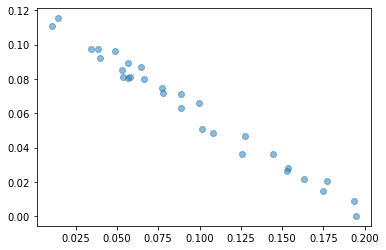

Pearson's R = -0.9906983371819762


In [34]:
# comparing X,Y | W
cond_df = sim_df[(sim_df["W"] > 6) & (sim_df["W"] < 6.5)]
cond_X = cond_df["X"]
cond_Y = cond_df["Y"]
correlation_diags(cond_X, cond_Y)

## Exercise
What variables can I condition on to make **Z** and **Y** d-separated?

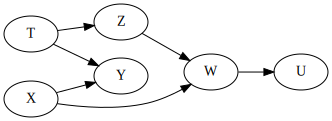

In [35]:
draw_dag(["TZ", "TY", "XW", "ZW", "WU", "XY"])

*Answers:*
- {T}
- {X,T}
- {W,X,T}
- {U,X,T}

Another example showing M-bias. Conditioning on all covariates should solve the problem, but what if **U** and **V** are unmeasured?

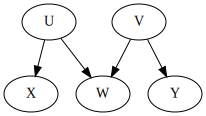

In [36]:
draw_dag(["UX", "UW", "VW", "VY"], horizontal = False)

# Interventional Distributions (do-notation)

## Adjustment Formula

Genrally, $P(Y|X=x)$ will not give you the effect of X on Y. To distinguish between **conidtioning** and **interventions**, we make use of the do notation:
$$P(Y|X=x) \neq P(Y|do(X=x))$$
$P(Y|do(X=x))$ conditions on a modified model where all **incoming arrows to X are removed**.

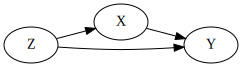

In [37]:
# original model
draw_dag(["XY","ZX","ZY"])

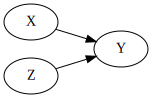

In [38]:
# modified model
draw_dag(["ZY","XY"])

$$P(Y|do(X=x)) = P_m(Y|X=x)$$
Why remove incoming arrows to X? By doing we are are **recreating a randomized trial** where X (treatment) is decided randomly. Since X is of affected by some random process, is should have no parent variables in the DAG.

The new distribution is also known as the **pseudopopulation** or **interventional distribution**.

The data generation process that produces X no longer depends on Z but becomes something we set, i.e. intervention.

But how do we get $P_m(X,Y,Z)$ given that we only know $P(X,Y,Z)$? Notice that aside from the arrows we removed, the other relationships should remain the same. i.e.:
$$P(Z=z) =  P_m(Z=z)$$
$$P(Y=y|X=x, Z=z) = P_m(Y=y|X=x, Z=z)$$
Using these we can how express components of $P_m$ in terms of $P$:
By definition,
$$P(Y=y|do(X=x)) = P_m(Y=y|X=x)$$
$$P(Y=y|do(X=x)) = \sum_z P_m(Y=y|X=x, Z=z)P_m(Z=z|X=x)$$
X and Z are d-separated in $P_m$ since Y is a collider which means that $P_m(Z=z|X=x) = P_m(Z=z)$
$$P(Y=y|do(X=x)) = \sum_z P_m(Y=y|X=x, Z=z)P_m(Z=z)$$
We can then replace the terms with the first 2 equations to get rid of the $P_m$ terms:
$$P(Y=y|do(X=x)) = \sum_z P(Y=y|X=x, Z=z)P(Z=z)$$

This is called the **Adjustment Formula**. In general, we have to control for all parents of X:
$$P(Y=y|do(X=x)) = \sum_z P(Y=y|X=x, PA=z)P(PA=z)$$
Notice that this can be expressed as:
$$P(Y=y|do(X=x)) = \sum_z \frac{P(X=x, Y=y PA=z)}{P(X=x|PA=z)}$$
$P(X=x|PA=z)$ is the **Propensity Score**, we have just derived Inverse Probability Weighting!

Now that we know how to evaluate $do(X=x)$, we can use it to express or solve for quantities such as the **Average Causal Effect** (ACE) or average treatment effect:
$$\text{ACE} = P(Y=1|do(X=1)) - P(Y=1|do(X=0))$$
We could also use it to express more complex expressions like multiple interventions for a subpopulation:
$$P(Y=y|do(X_1 = x_1, X_2 = x_1), W=w)$$

## Backdoor Criterion
The adjustment formula would not work if some parents of X are unmeasured. Even so, we may still be able to estimate causal effects using the backdoor criterion. For the graph below, assume that U is unmeasured and we are interested in the effect of X on Y:

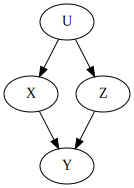

In [39]:
draw_dag(["XY", "UX", "UZ", "ZY"], horizontal = False)

The backdoor criterion is given by
$$P(Y=y|do(X=x)) = \sum_z P(Y=y|X=x, Z=z)P(Z=z)$$
where Z is a set of variables to condition on to block all paths from X to Y except for the direct path. In the example above, we are still able to get $P(Y=y|do(X=x))$ even if the parent of X, variable U, is unmeasured.

### Relation to Potential Outcomes
How is $E[Y_{X=x}]$ related to $E[Y|do(X=x)]$? Conceptually, they are different. Potential outcomes try to determine $E[Y]$ had *everyone* received treatment x. Meanwhile $E[Y|do(X=x)]$ just gets the subset with treatment x in the adjusted/pseudopopulation (no counterfactuals were assumed).

But they turn out to be equivalent due to the **conditional exchangeability** assumption:
$$Y_{X=x}\perp\!\!\!\perp X|Z$$

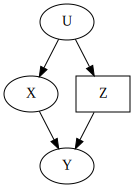

In [40]:
draw_dag(["XY", "UX", "UZ", "ZY"], condition_on=["Z"], horizontal = False)

In some cases, we don't need to control for anything. In the example below, controlling for W will actually bias the result. 

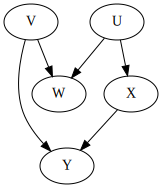

In [41]:
draw_dag(["UX", "UW", "VW", "VY", "XY"], horizontal = False)

### Other things that can go wrong when we condition without knowing the DAG:

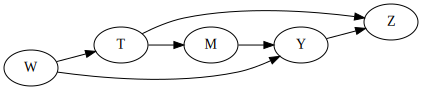

In [42]:
draw_dag(["TM","MY", "WT", "WY", "TZ", "YZ"])

To get the effect of T on Y:
- we should condition on W only
- conditioning on M will block the causal effect of T on Y
- conditioning on Z will open the other backdoor path from T to Y

 ## Front-Door Criterion
 - The backdoor criterion is not the only way of estimating causal effects! (i.e. it is sufficient but not necessary)
 - There are cases when the graphical structure doesn't allow us to create the pseudopopulation (i.e. we cannot block all backdoor paths).

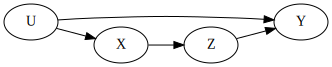

In [43]:
# For example:
draw_dag(["UX", "XZ", "ZY", "UY"])

- Here, U is unmeasured.
- A famous example of this is the smoking-lung cancer debate where tobacco companies argued that there is some unmeasured confounder U, a genotype that causes both lung cancer and craving for nicotine. (Such a genotype, if it even exists, will be difficult to detect!)
- Turns out that there is another variable that is more readily measurable! Tar in the subjects lungs (Z). We can use the front door criterion to estimate the effect using Z.

$$P(Y=y|do(X=x)) = \sum_zP(Y=y|do(Z=z))P(Z=z|do(X=x))$$
Intuitively, it is as though we are running 2 experiments: one estimating the effect of X on Z, the other estimating the effect of Z on Y, then we just combine the results afterwards.
This can be further simplified. Notice that since Y is a collider
$$P(Z=z|do(X=x)) = P(Z=z|X=x)$$
and that $P(Y=y|do(Z=z))$ can be estimated using the backdoor criterion adjusting for X. Thus,
$$P(Y=y|do(X=x)) = \sum_z\sum_{x'}P(Y=y|Z=z, X=x')P(X=x')P(Z=z|X=x)$$

Generally, this works for a set of variables *Z* that satisfy the following conditions:
1. Z intercepts all directed paths from X to Y.
2. There is no unblocked path from X to Z.
3. All backdoor paths from Z to Y are blocked by X.

Aside from the adjustment formula and the backdoor and frontdoor criteria, there is a more general method for getting the pseudopopulation $do(X=x)$ called **do-calculus**. Plus, there are programs that can implement the do-calculus (if possible) automatically. It has been proven that the do-calculus is complete -- that is , it can identify all identifiable causal associations.

## Mediation (Direct effect)
In some cases, the treatment variable may affect the outcome *directly* or *indirectly* and we are interested in separating these effects. For example,

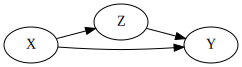

In [44]:
draw_dag(["XZ","ZY","XY"])

Notice that X can affect Y directly or indirectly thru Z. Here, Z is called the **mediating variable**. A sample use case is checking for gender bias in hiring. In this case, the mediating variable may be preference or qualification -- it could be that the position is prefered by one gender over the other. 

The problem becomes more complicated when there is a confounder between mediator and outcome. 

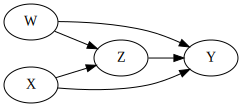

In [45]:
draw_dag(["XZ","ZY","XY","WY","WZ"])

In this case, we cannot simply condition on Z (because of confounder W), so we must instead *intervene* on Z. Thus the **Controlled Direct Effect (CDE)** is given by
$$CDE = P(Y=y|do(X=x), do(Z=z)) - P(Y=y|do(X=x'), do(Z=z))$$
This notation hold regardless of the structure of the DAG!

From the example above, the intuition is that for there to be no gender bias, a highly qualified male applicant and a highly qualified female applicant should have the same probability of getting hired.

**If the relationships between variables were linear** we could compute the indirect effect by simply using:
$$TE = DE + IE$$
But if they aren't linear, we have to rely on SCMs and counterfactuals which won't be covered in this presentation.

# Conclusion
- Knowing the DAG is a good supplement to current methods. It helps us determine the subset of variables we need to control.
- It also helps us avoid pitfalls when controlling for variables, we avoid controlling "blindly".
- Better transparency -- DAGs make our assumptions clear, they also let us determine what is possible (or not) with our data.


# References
- Pearl 2016, Causal Inference in Statistics: A Primer.
- Neal 2020, Introdunction to Causal Inference from a Machine Learning Perspective
- Bayesian Network Wikipedia Page 
(https://en.wikipedia.org/wiki/Bayesian_network)